## 3 Chamber Sociability test - Behavioural analysis

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy.stats import ttest_ind, f_oneway

from shared.helper_functions import *

Get the path to the folder that holds the behaviour data exported from BORIS software.

In [5]:
behaviour_data_dir = select_folder("Please select the sociability behaviour data directory")

2024-04-22 13:43:12.903 python[8585:785138] +[CATransaction synchronize] called within transaction


If you want to save plots, select a directory you want to save them to.

In [ ]:
plot_output_dir = select_or_create_folder("Please select or create a folder you wish to save the plots")

## Load the animal metadata

First, let's load the metadata that tells us which batch/cage combination is which animal (id).

In [3]:
all_animals_metadata = select_file("Please select the file holding metadata for all animals")
metadata = pd.read_excel(all_animals_metadata)
metadata

,mouseId,genotype,mouseName,arena,batch,RFID,birthday,weight,sex,species,type,notes
0,78211,DRD2-KO,1.1,1.0,1,4518,2023-04-03,26.6,M,MusMusculus,experimental,NaN
1,78212,DRD2-HET,1.2,1.0,1,4513,2023-04-03,25.6,M,MusMusculus,stimulus,NaN
2,78213,CreWT,1.3,1.0,1,4517,2023-04-03,27.7,M,MusMusculus,stimulus,NaN
3,78210,CreWT,1.4,1.0,1,4521,2023-04-03,26.1,M,MusMusculus,stimulus,NaN
4,78233,DRD2-WT,1.5,2.0,1,4507,2023-04-05,24.6,M,MusMusculus,experimental,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
91,39498,CreWT,6.4,NaN,6,4553,2023-08-16,NaN,M,MusMusculus,stimulus,NaN
92,39508,DRD2-WT,6.5,NaN,6,4564,2023-08-15,NaN,M,MusMusculus,experimental,NaN
93,39499,DRD-HET,6.6,NaN,6,4557,2023-08-15,NaN,M,MusMusculus,stimulus,NaN
94,39507,CreWT,6.7,NaN,6,4571,2023-08-16,NaN,M,MusMusculus,stimulus,NaN


As the behaviour was tracked with Boris and saved to a separate file per animal, we load the files separately and merge them into one dataframe.

Note: animal from batch 5 cage 1 does not have an EEG file (transmitter was broken at the time), therefore there is not entry in the metadata file for that animal.

This means we have the following animals:

* batch1:
    * cage1: 78211 - 1.1
    * cage2: 78233 - 1.5
    * cage3: 78227 - 1.9
    * cage4: 78244 - 1.13
* batch2:
    * cage1: 79593 - 2.1
    * cage2: 79592 - 2.5
    * cage3: 79604 - 2.9
    * cage4: 79602 - 2.13
* batch4:
    * cage1: 80620 - 4.1
    * cage2: 80625 - 4.5
    * cage3: 80630 - 4.9
* batch5:
    * cage1: 81167 - 5.1 (no EEG)  
    * cage2: 81175 - 5.5
    * cage3: 81207 - 5.9
    * cage4: 81193 - 5.13
* batch5b:
    * cage1: 81217 - 5.17
    * cage2: 81218 - 5.21
* batch6:
    * cage1: 39489 - 6.1
    * cage2: 39508 - 6.5

With the above information we can create a dictionary that holds the batch-cage combination as keys, and the subject identifiers as values. These can be used to get the genotype that belongs to the individual animals.

In [4]:
subject_id_dict = {
    'batch1_cage1': 78211, 'batch2_cage1': 79593, 'batch5_cage1': 81167, 'batch4_cage1': 80620, 'batch5b_cage1': 81217, 'batch6_cage1': 39489,
    'batch1_cage2': 78233, 'batch2_cage2': 79592, 'batch5_cage2': 81175, 'batch4_cage2': 80625, 'batch5b_cage2': 81218, 'batch6_cage2': 39508,
    'batch1_cage3': 78227, 'batch2_cage3': 79604, 'batch5_cage3': 81207, 'batch4_cage3': 80630,
    'batch1_cage4': 78244, 'batch2_cage4': 79602, 'batch5_cage4': 81193,
}

## Data pre-processing

The data that is exported from the BORIS tracking application provides two rows per state-event. One represents the start of the event, and one the stop, each having a single timestamp.

We want to merge these rows and immediately calculate the duration of the (non)social cup state-event interaction. Let's do this first.

To do so, we define a function that merges some information from the START and the STOP rows.

In [5]:
def merge_event_rows(beh_data):
    merged_df = pd.concat([
        beh_data.iloc[::2].reset_index(drop=True),  # only keep each start row
        beh_data.iloc[::2].reset_index(drop=True)['Image index'].rename('Frame start'),  # interaction start frame, name it 'Frame start'
        beh_data.iloc[1::2].reset_index(drop=True)['Image index'].rename('Frame stop'),  # interaction stop frame, name it 'Frame stop'
        beh_data.iloc[1::2].reset_index(drop=True)['Time'] - beh_data.iloc[::2]['Time'].reset_index(drop=True),  # interaction duration
    ], axis=1)
    # rename the last column as it represents the duration of the interaction
    merged_df = merged_df.set_axis([*merged_df.columns[:-1], 'Interaction duration'], axis=1)
    # drop the columns we don't need
    cols_to_drop = ['Image index', 'Time', 'Observation type', 'Source', 'Time offset (s)', 'Subject', 'Comment', 'Image file path', 'Description', 'Behavioral category', 'Behavior type']
    return merged_df.drop(columns=cols_to_drop)

Then, we create one dataframe holding the behavioural data for all animals. Each row is one interaction event.

In [6]:
beh_df = pd.DataFrame()

# for each behaviour file (which holds behaviour data on one animal only)
for file in os.listdir(behaviour_data_dir):
    if not file.endswith('.xlsx') and 'batch' not in file:
        continue
        
    beh_dat = pd.read_excel(os.path.join(behaviour_data_dir, file))
    
    # get the subject id
    batch, cage = beh_dat['Observation id'].iloc[0].split('_')[:2]
    batch_cage = batch + '_' + cage
    subject_id = subject_id_dict[batch_cage]
    genotype = metadata[metadata.mouseId == subject_id]['genotype'].iloc[0]

    social_cup_starts = beh_dat[(beh_dat['Behavior type'] == 'START') & (beh_dat['Behavior'] == 'social_cup')]
    social_cup_stops = beh_dat[(beh_dat['Behavior type'] == 'STOP') & (beh_dat['Behavior'] == 'social_cup')]
    non_social_cup_starts = beh_dat[(beh_dat['Behavior type'] == 'START') & (beh_dat['Behavior'] == 'non-social_cup')]
    non_social_cup_stops = beh_dat[(beh_dat['Behavior type'] == 'STOP') & (beh_dat['Behavior'] == 'non-social_cup')]
    
    if not len(social_cup_starts) == len(social_cup_stops) or not len(non_social_cup_starts) == len(non_social_cup_stops):
        print(f'Number of event STARTs and STOPs do not match, skipping {beh_dat["Observation id"]} (id: {subject_id_dict[beh_dat["Observation id"]]})')
        continue
    
    # merge the start and stop rows and calculate some stuff (interaction duration etc)
    beh_data = merge_event_rows(beh_dat)
    beh_data.insert(1, 'subject_id', subject_id)
    beh_data.insert(2, 'genotype', genotype)
    beh_df = pd.concat([beh_df, beh_data], axis=0)

Let's inspect the dataframe

In [7]:
beh_df.head()

,Observation id,subject_id,genotype,Observation date,Observation duration,Media duration (s),FPS,Behavior,Media file name,Frame start,Frame stop,Interaction duration
0,batch5_cage4,81193,DRD2-KO,2024-04-10 12:12:27.573,608.327,1858.755,60.0,social_cup,C:/Users/Olle de Jong/Documents/MSc Biology/rp...,37380,37609,7.636
1,batch5_cage4,81193,DRD2-KO,2024-04-10 12:12:27.573,608.327,1858.755,60.0,non-social_cup,C:/Users/Olle de Jong/Documents/MSc Biology/rp...,37704,37720,0.566
2,batch5_cage4,81193,DRD2-KO,2024-04-10 12:12:27.573,608.327,1858.755,60.0,non-social_cup,C:/Users/Olle de Jong/Documents/MSc Biology/rp...,37764,37809,1.501
3,batch5_cage4,81193,DRD2-KO,2024-04-10 12:12:27.573,608.327,1858.755,60.0,non-social_cup,C:/Users/Olle de Jong/Documents/MSc Biology/rp...,37840,37881,1.367
4,batch5_cage4,81193,DRD2-KO,2024-04-10 12:12:27.573,608.327,1858.755,60.0,non-social_cup,C:/Users/Olle de Jong/Documents/MSc Biology/rp...,37941,38051,3.667


In [8]:
print(f'Subjects/animals present (n={len(np.unique(beh_df["subject_id"]))}):\n{np.unique(beh_df["subject_id"])} ')

Subjects/animals present (n=19):
[39489 39508 78211 78227 78233 78244 79592 79593 79602 79604 80620 80625
 80630 81167 81175 81193 81207 81217 81218] 


## Sociability metric calculations

In [9]:
behaviour_stats = pd.DataFrame()

# for each behaviour file (which holds behaviour data on one animal only)
for subject_id in np.unique(beh_df["subject_id"]):
    
    subject_data = beh_df[beh_df["subject_id"] == subject_id]
    
    mean_interaction_duration = np.mean(subject_data['Interaction duration'])
    interaction_ratio = len(subject_data[subject_data['Behavior'] == 'social_cup']) / len(subject_data[subject_data['Behavior'] == 'non-social_cup'])
    total_interaction_duration_per_behavior = subject_data.groupby('Behavior')['Interaction duration'].sum()
    
    # Sociability Index = (Time in social chamber - Time in non-social chamber) / (Time in social chamber + Time in non-social chamber)
    sociability_index = (total_interaction_duration_per_behavior['social_cup'] -  total_interaction_duration_per_behavior['non-social_cup']) /  (total_interaction_duration_per_behavior['social_cup'] + total_interaction_duration_per_behavior['non-social_cup'])
    
    # sociability index (# interactions)
    sociability_index_n_interactions = (len(subject_data[subject_data['Behavior'] == 'social_cup']) -  len(subject_data[subject_data['Behavior'] == 'non-social_cup'])) /  (len(subject_data[subject_data['Behavior'] == 'social_cup']) + len(subject_data[subject_data['Behavior'] == 'non-social_cup']))
    
    temp = pd.DataFrame({
        'subject_id': subject_id,
        'genotype': subject_data['genotype'].iloc[0],
        'total_interactions' : len(subject_data),
        'total_interaction_time': np.sum(total_interaction_duration_per_behavior.values),
        'interaction_ratio': interaction_ratio,
        'total_social_interaction_duration': total_interaction_duration_per_behavior['social_cup'],
        'total_non_social_interaction_duration': total_interaction_duration_per_behavior['non-social_cup'],
        'average_interaction_duration': mean_interaction_duration,
        'sociability_index_n_interactions': sociability_index_n_interactions,
        'sociability_index_interaction_duration': sociability_index,
    }, index=[0])
    behaviour_stats = pd.concat([behaviour_stats, temp], ignore_index=True)

Let's inspect these metrics a bit

In [10]:
behaviour_stats.head()

,subject_id,genotype,total_interactions,total_interaction_time,interaction_ratio,total_social_interaction_duration,total_non_social_interaction_duration,average_interaction_duration,sociability_index_n_interactions,sociability_index_interaction_duration
0,39489,DRD2-KO,58,281.073,1.071429,160.630,120.443,4.846086,0.034483,0.142977
1,39508,DRD2-WT,42,170.470,0.500000,40.451,130.019,4.058810,-0.333333,-0.525418
2,78211,DRD2-KO,52,136.847,0.677419,72.823,64.024,2.631673,-0.192308,0.064298
3,78227,DRD2-KO,40,156.922,1.222222,96.833,60.089,3.923050,0.100000,0.234155
4,78233,DRD2-WT,62,176.159,0.722222,83.759,92.400,2.841274,-0.161290,-0.049052


In [11]:
behaviour_stats.describe()

,subject_id,total_interactions,total_interaction_time,interaction_ratio,total_social_interaction_duration,total_non_social_interaction_duration,average_interaction_duration,sociability_index_n_interactions,sociability_index_interaction_duration
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,75755.526316,51.578947,177.710579,1.072686,100.391105,77.319474,3.497510,-0.002650,0.120905
std,12826.630203,10.558387,39.800641,0.460464,34.558117,26.147037,0.676022,0.185779,0.247972
min,39489.000000,31.000000,113.650000,0.500000,40.451000,49.614000,2.557704,-0.333333,-0.525418
25%,78238.500000,44.000000,153.689000,0.731481,81.434500,58.905000,2.996795,-0.155113,-0.017334
50%,79604.000000,51.000000,166.629000,0.961538,87.963000,67.260000,3.399143,-0.019608,0.174814
75%,81171.000000,58.500000,209.493000,1.261111,119.576500,90.150000,3.899072,0.115217,0.296575
max,81218.000000,71.000000,281.073000,2.470588,162.888000,134.017000,4.846086,0.423729,0.476712


In [12]:
np.unique(behaviour_stats.genotype, return_counts=True)

(array(['DRD2-KO', 'DRD2-WT'], dtype=object), array([10,  9]))

Let's boxplot the calculated interaction metrics per genotype

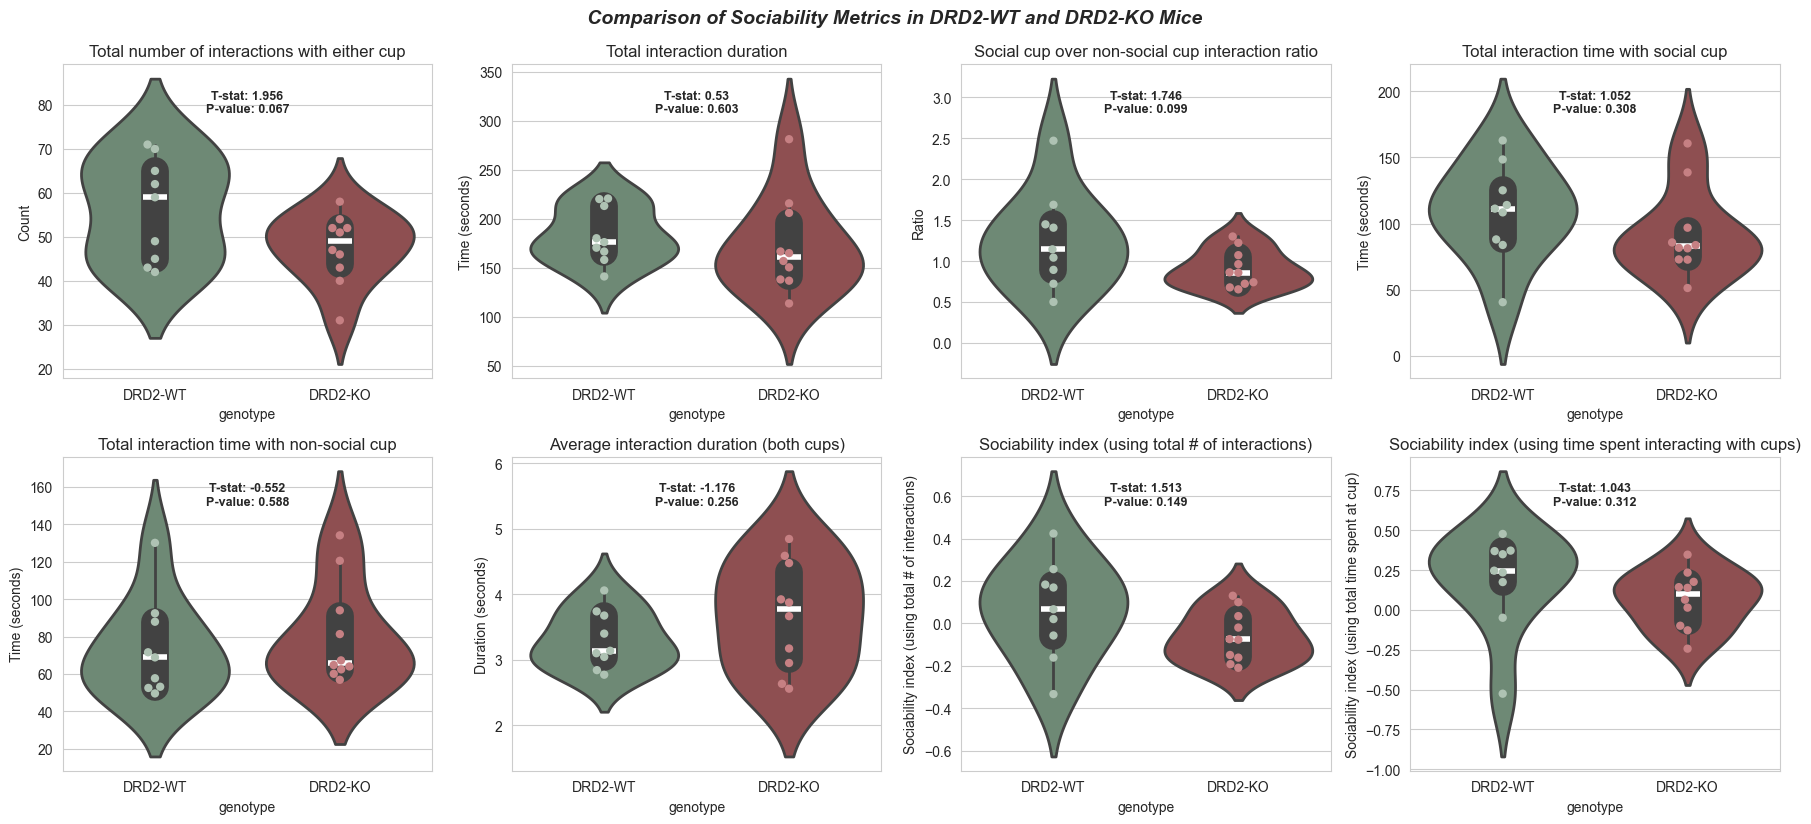

In [13]:
behaviour_stats = behaviour_stats.sort_values(by='genotype', ascending=False)
boxplot_cols = behaviour_stats.columns[2:]

swarmplot_palette = {'DRD2-WT':'#AEC2B3', 'DRD2-KO':'#C68083'}
violin_palette = {'DRD2-WT':'#6A8D73', 'DRD2-KO':'#984447'}

title_label_dict = {
    'total_interactions': ('Total number of interactions with either cup', 'Count'),
    'total_interaction_time': ('Total interaction duration', 'Time (seconds)'),
    'interaction_ratio': ('Social cup over non-social cup interaction ratio', 'Ratio'),
    'total_social_interaction_duration': ('Total interaction time with social cup', 'Time (seconds)'),
    'total_non_social_interaction_duration': ('Total interaction time with non-social cup', 'Time (seconds)'),
    'average_interaction_duration': ('Average interaction duration (both cups)', 'Duration (seconds)'),
    'sociability_index_n_interactions': ('Sociability index (using total # of interactions)', 'Sociability index (using total # of interactions)'),
    'sociability_index_interaction_duration': ('Sociability index (using time spent interacting with cups)', 'Sociability index (using total time spent at cup)'),
}

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
axs = axs.ravel()

for i, metric in enumerate(boxplot_cols):
    wt_metric_data = behaviour_stats[behaviour_stats.genotype == 'DRD2-WT'][metric]
    ko_metric_data = behaviour_stats[behaviour_stats.genotype == 'DRD2-KO'][metric]

    t_statistic, p_val = ttest_ind(wt_metric_data, ko_metric_data)
    
    sns.violinplot(data=behaviour_stats, x='genotype', hue='genotype', y=metric, ax=axs[i], linewidth=2, inner_kws=dict(box_width=20, whis_width=2), palette=violin_palette)
    sns.swarmplot(data=behaviour_stats, x='genotype', hue='genotype', y=metric, ax=axs[i], color="white", edgecolor="auto", s=6, palette=swarmplot_palette)
    
    y_range = axs[i].get_ylim()
    offset = 0.08 * (y_range[1] - y_range[0])
    
    axs[i].text(0.5, y_range[1] - offset, f'T-stat: {round(t_statistic, 3)}\nP-value: {round(p_val, 3)}', ha='center', va='top', fontsize=9, fontweight='bold')
    axs[i].set_title(title_label_dict[metric][0])
    axs[i].set_ylabel(title_label_dict[metric][1])
    
fig.tight_layout()
plt.suptitle('Comparison of Sociability Metrics in DRD2-WT and DRD2-KO Mice', fontsize=14, fontweight='bold', fontstyle='italic', y=1.025)
plt.show()
# save_figure(os.path.join(plot_output_dir, 'behavioural_analysis/violin_grid_v2.pdf'))

In [175]:
for i, metric in enumerate(boxplot_cols):
    print(f'\n{metric}')
    wt_metric_data = behaviour_stats[behaviour_stats.genotype == 'DRD2-WT'][metric]
    ko_metric_data = behaviour_stats[behaviour_stats.genotype == 'DRD2-KO'][metric]
    
    # perform independent t-test to compare means
    result = ttest_ind(wt_metric_data, ko_metric_data)

    print("T-statistic:", result.statistic)
    print("P-value:", result.pvalue)
    
    f_statistic, p_value = f_oneway(wt_metric_data, ko_metric_data)

    print("F-statistic:", f_statistic)
    print("P-value:", p_value)


total_interactions
T-statistic: 1.9561216113752748
P-value: 0.06708713937551813
F-statistic: 3.8264117584894013
P-value: 0.06708713937551822

total_interaction_time
T-statistic: 0.5299882503007375
P-value: 0.602974156246012
F-statistic: 0.2808875454568361
P-value: 0.6029741562460129

interaction_ratio
T-statistic: 1.7463149424035747
P-value: 0.0987990259935433
F-statistic: 3.049615878061999
P-value: 0.09879902599354339

total_social_interaction_duration
T-statistic: 1.0519740169982652
P-value: 0.3075357078311716
F-statistic: 1.1066493324394655
P-value: 0.30753570783117146

total_non_social_interaction_duration
T-statistic: -0.5519412170506541
P-value: 0.5881717538274838
F-statistic: 0.3046391070793584
P-value: 0.5881717538274835

average_social_cup_duration
T-statistic: -1.6095835454542815
P-value: 0.12589987023477503
F-statistic: 2.5907591897971773
P-value: 0.12589987023477509

average_non_social_cup_duration
T-statistic: -0.9535684122095387
P-value: 0.3536653453237054
F-statistic: 0

If there's any trend to be noticed, the KOs seem to be less social.

### Outlier investigation

In [56]:
behaviour_stats

,subject_id,genotype,interaction_ratio,total_interaction_time,total_social_interaction_duration,total_non_social_interaction_duration,average_social_cup_duration,average_non_social_cup_duration,sociability_index
12,80630,DRD2-WT,1.407407,180.127,111.269,68.858,2.928132,2.550296,0.235451
17,81217,DRD2-WT,1.687500,158.053,108.439,49.614,4.016259,3.100875,0.372185
16,81207,DRD2-WT,0.891892,213.043,125.143,87.900,3.792212,2.375676,0.174814
4,78233,DRD2-WT,0.722222,176.159,83.759,92.400,3.221500,2.566667,-0.049052
5,78244,DRD2-WT,1.041667,166.558,114.010,52.548,4.560400,2.189500,0.369013
8,79602,DRD2-WT,1.142857,141.154,87.963,53.191,3.665125,2.532905,0.246341
1,39508,DRD2-WT,0.500000,170.470,40.451,130.019,2.889357,4.643536,-0.525418
10,80620,DRD2-WT,1.448276,220.077,148.487,71.590,3.535405,2.468621,0.349410
13,81167,DRD2-WT,2.470588,220.609,162.888,57.721,3.878286,3.395353,0.476712
11,80625,DRD2-KO,0.722222,113.650,51.192,62.458,3.937846,3.469889,-0.099129


When looking at the sociability index, it seems like there's one WT subject that scores very low, with a value of approximately -0.52.

In [68]:
behaviour_stats.iloc[6]

subject_id                                  39508
genotype                                  DRD2-WT
interaction_ratio                             0.5
total_interaction_time                     170.47
total_social_interaction_duration          40.451
total_non_social_interaction_duration     130.019
average_social_cup_duration              2.889357
average_non_social_cup_duration          4.643536
sociability_index                       -0.525418
Name: 1, dtype: object

It seems that it is a batch 6 animal, namely 39508. Let's investigate the metrics compared to the other animals a bit more in depth

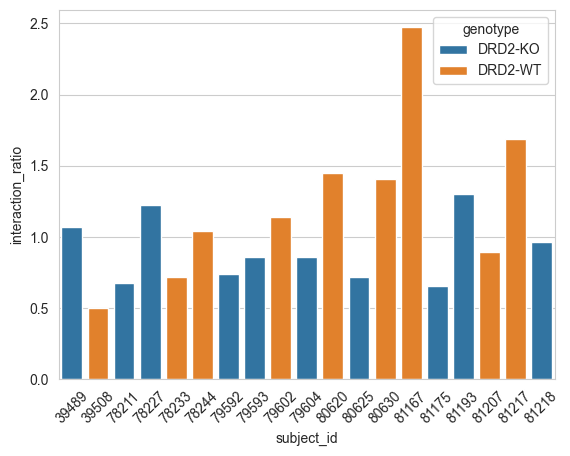

In [162]:
sns.barplot(x=behaviour_stats.subject_id, y=behaviour_stats.interaction_ratio, hue=behaviour_stats.genotype)
plt.xticks(rotation=45)
plt.show()

It seems like the interaction ratiois the lowest of all animals. It explored the social and non-social cup equally often/

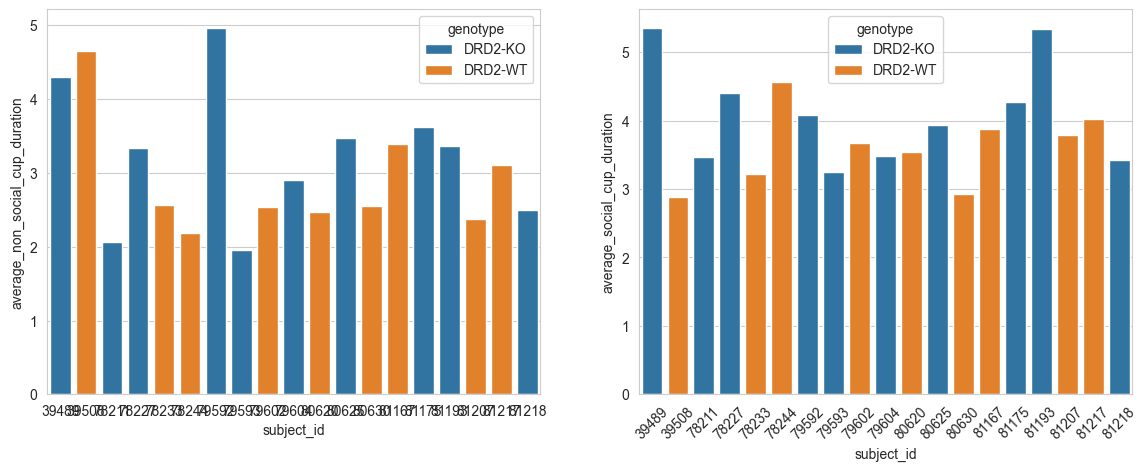

In [163]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs = axs.ravel()
sns.barplot(ax=axs[0], x=behaviour_stats.subject_id, y=behaviour_stats.average_non_social_cup_duration, hue=behaviour_stats.genotype)
sns.barplot(ax=axs[1], x=behaviour_stats.subject_id, y=behaviour_stats.average_social_cup_duration, hue=behaviour_stats.genotype)
plt.xticks(rotation=45)
plt.show()

And it seems like the visits of this animal to the social cup where very short on average, while the visits to the non-social cup on average were quite long.

### Interaction duration distribution

In [84]:
beh_df.head()

,Observation id,subject_id,genotype,Observation date,Observation duration,Media duration (s),FPS,Behavior,Media file name,Frame start,Frame stop,Interaction duration
0,batch5_cage4,81193,DRD2-KO,2024-04-10 12:12:27.573,608.327,1858.755,60.0,social_cup,C:/Users/Olle de Jong/Documents/MSc Biology/rp...,37380,37609,7.636
1,batch5_cage4,81193,DRD2-KO,2024-04-10 12:12:27.573,608.327,1858.755,60.0,non-social_cup,C:/Users/Olle de Jong/Documents/MSc Biology/rp...,37704,37720,0.566
2,batch5_cage4,81193,DRD2-KO,2024-04-10 12:12:27.573,608.327,1858.755,60.0,non-social_cup,C:/Users/Olle de Jong/Documents/MSc Biology/rp...,37764,37809,1.501
3,batch5_cage4,81193,DRD2-KO,2024-04-10 12:12:27.573,608.327,1858.755,60.0,non-social_cup,C:/Users/Olle de Jong/Documents/MSc Biology/rp...,37840,37881,1.367
4,batch5_cage4,81193,DRD2-KO,2024-04-10 12:12:27.573,608.327,1858.755,60.0,non-social_cup,C:/Users/Olle de Jong/Documents/MSc Biology/rp...,37941,38051,3.667


Let's show the distribution of social, and non-social visits.

In [111]:
print(f'There are {len(beh_df[beh_df.Behavior == "social_cup"])} social cup observations, and {len(beh_df[beh_df.Behavior == "non-social_cup"])} non-social cup observations')

There are 494 social cup observations, and 486 non-social cup observations


In [62]:
print(f'Total average interaction duration: {np.mean(beh_df["Interaction duration"])}')

Total average interaction duration: 3.4454091836734677


So there's not that much difference in group size

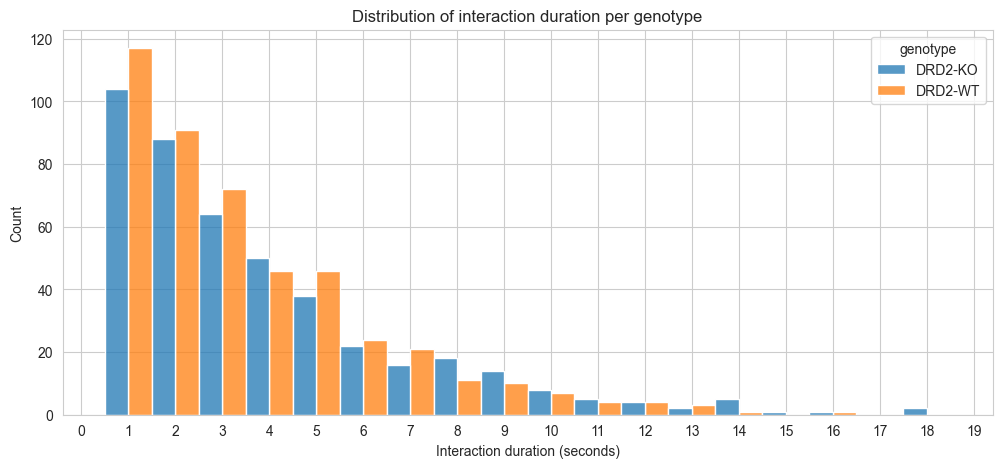

In [40]:
fig = plt.figure(figsize=(12, 5))
sns.histplot(data=beh_df, x=beh_df['Interaction duration'], hue=beh_df.genotype, multiple='dodge', bins=[i + 0.5 for i in range(0, 19)])
plt.xticks(range(0, 20, 1))
plt.title("Distribution of interaction duration per genotype")
plt.xlabel("Interaction duration (seconds)")
plt.show()

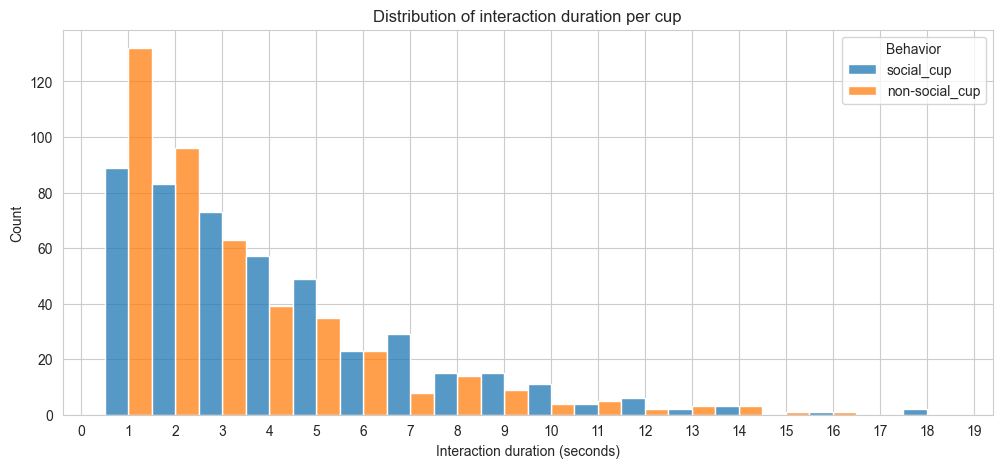

In [41]:
fig = plt.figure(figsize=(12, 5))
sns.histplot(data=beh_df, x=beh_df['Interaction duration'], hue=beh_df.Behavior, multiple='dodge', bins=[i + 0.5 for i in range(0, 19)])
plt.xticks(range(0, 20, 1))
plt.title("Distribution of interaction duration per cup")
plt.xlabel("Interaction duration (seconds)")
plt.show()

### Interaction duration over time

Let us generate a grid plot that displays the interaction duration over the course of the experiment for each subject (10 minutes)

In [30]:
beh_df.head()

,Observation id,subject_id,genotype,Observation date,Observation duration,Media duration (s),FPS,Behavior,Media file name,Frame start,Frame stop,Interaction duration
0,batch5_cage4,81193,DRD2-KO,2024-04-10 12:12:27.573,608.327,1858.755,60.0,social_cup,C:/Users/Olle de Jong/Documents/MSc Biology/rp...,37380,37609,7.636
1,batch5_cage4,81193,DRD2-KO,2024-04-10 12:12:27.573,608.327,1858.755,60.0,non-social_cup,C:/Users/Olle de Jong/Documents/MSc Biology/rp...,37704,37720,0.566
2,batch5_cage4,81193,DRD2-KO,2024-04-10 12:12:27.573,608.327,1858.755,60.0,non-social_cup,C:/Users/Olle de Jong/Documents/MSc Biology/rp...,37764,37809,1.501
3,batch5_cage4,81193,DRD2-KO,2024-04-10 12:12:27.573,608.327,1858.755,60.0,non-social_cup,C:/Users/Olle de Jong/Documents/MSc Biology/rp...,37840,37881,1.367
4,batch5_cage4,81193,DRD2-KO,2024-04-10 12:12:27.573,608.327,1858.755,60.0,non-social_cup,C:/Users/Olle de Jong/Documents/MSc Biology/rp...,37941,38051,3.667


In [31]:
print(len(beh_df.subject_id.unique()))

19


Plot the interaction duration over the interaction number for one subject 

In [32]:
data = beh_df[beh_df.subject_id == 80630]

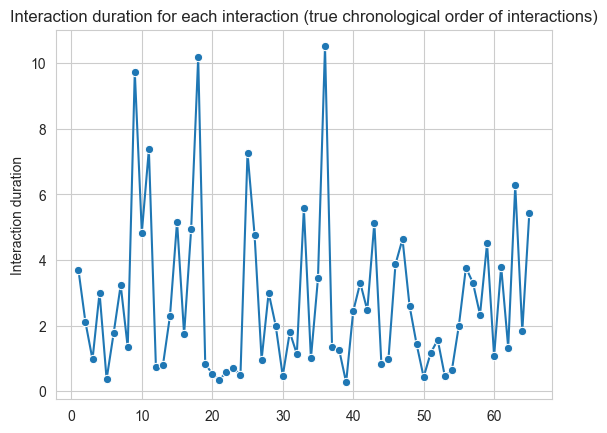

In [33]:
sns.lineplot(data=data, x=range(1,len(data)+1), y='Interaction duration', marker='o')
plt.title("Interaction duration for each interaction (true chronological order of interactions)")
plt.show()

And now with the start frame of the interaction on the x-axis

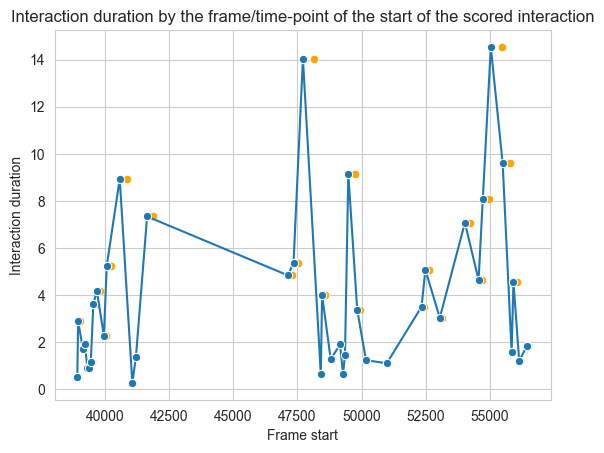

In [55]:
sns.lineplot(data=data, x='Frame start', y='Interaction duration', marker='o')
sns.scatterplot(data=data, x='Frame stop', y='Interaction duration', marker='o', color='orange')
plt.title("Interaction duration by the frame/time-point of the start of the scored interaction")
plt.show()

Now, let's plot this last one for all subjects in a grid

In [61]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(35, 30), sharey=True)
axs = axs.ravel()

for i, subj_id in enumerate(beh_df.subject_id.unique()):
    data = beh_df[beh_df.subject_id == subj_id]
    x = data['Frame start'] / 30 / 60  # to minutes
    x2 = data['Frame stop'] / 30 / 60
    sns.lineplot(data=data, x=x, y='Interaction duration', ax=axs[i], marker='o', label='Start interaction')
    sns.scatterplot(data=data, x=x2, y='Interaction duration', ax=axs[i], marker='o', color='orange', label='Stop interaction')
    axs[i].set_xlabel('Start of interaction (minutes)')
    axs[i].set_title(f'Subject id: {subj_id}, genotype: {data.genotype.iloc[0]}')
    plt.legend()

axs[-1].remove()
plt.tight_layout()
save_figure(os.path.join(plot_output_dir, f'behavioural_analysis/interaction_duration_trend_grid.pdf'))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

Subjects 78227, 78244, 80625, 79602, 79592, 81175, 81193 all seem to have a significant stretch (around two minutes) where they did not interact with any cup. Is there something there?

In [153]:
behaviour_stats[behaviour_stats.subject_id.isin([78227, 78244, 80625, 79602, 79592, 81175, 81193])].loc[:,['subject_id', 'genotype']]

,subject_id,genotype
5,78244,DRD2-WT
8,79602,DRD2-WT
11,80625,DRD2-KO
15,81193,DRD2-KO
14,81175,DRD2-KO
6,79592,DRD2-KO
3,78227,DRD2-KO


Interestingly, 5 out of 7 are KOs.

Also, it does not really seem like the animals become less interested over time.

Lets save a figure per subject that displays the trend of the interaction duration over the course of the experiment (10 minutes)

In [51]:
for i, subj_id in enumerate(beh_df.subject_id.unique()):
    data = beh_df[beh_df.subject_id == subj_id]
    sns.lmplot(data=data, x='Frame start', y='Interaction duration', aspect=1.5)
    plt.title(f'Interaction duration over the course of the experiment (Subject {subj_id}, genotype: {data.genotype.iloc[0]})')
    save_figure(os.path.join(plot_output_dir, f'behavioural_analysis/interaction_duration_trends/{subj_id}.pdf'))